In [1]:
%cd ..

/home/zengyun1/gnn/TMP_NN


/home/zengyun1/App/miniconda3/envs/gnn/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import torch
import pickle
with open('Dataset/Bergman_cyclization.pkl', 'rb') as file:
    data_list = pickle.load(file)

In [8]:
from torch.utils.data import TensorDataset, DataLoader,random_split

def get_datalist(data_list,atom_list):
    data_size = len(data_list)
    atom_num = len(atom_list)
    x3d_total = torch.empty(data_size, atom_num, 8, 8, 8)  
    x2d_total = torch.empty(data_size, atom_num, 10, 20)
    x1d_total = torch.empty(data_size, atom_num, 23)
    x0d_total = torch.empty(data_size, 13)  # 
    y_total = torch.empty(data_size, 1)  
    for idx, G in enumerate(data_list):
        x3d_total[idx] = G.x3d[atom_list, :, :, :]
        x2d_total[idx] = G.x2d[atom_list, :, :]
        x1d_total[idx] = G.x[atom_list, :23]
        x0d_total[idx] = G.global_features

        # x0d_total[idx] = torch.cat((G.global_features[:1], G.global_features[3:]))
        y_total[idx] = G.y

    dataset = TensorDataset(x3d_total, x2d_total, x1d_total, x0d_total, y_total)
    return dataset

In [21]:
def train_and_test(atom_list,data_list):
    
    atom_num = len(atom_list)
    dataset = get_datalist(data_list,atom_list)
    
    train_size = int(0.80 * len(dataset))
    test_size = len(dataset) - train_size
    
    torch.manual_seed(2025)
    # Randomly partition the data set
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
    
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    criterion = nn.MSELoss()
    criterion2 = nn.L1Loss()
    model=MultimodalMoleculeNet().to(device)
    
    total_actuals = []
    total_predictions = []
    train_loss_list = []
    val_loss_list = []
    LR = 0.01
    
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)  # 定义优化器
    scheduler = StepLR(optimizer, step_size=10, gamma=0.9)  # 定义学习率调度器
    num_epochs = 1000
    
    lr_list = []  # 列表来存储每个epoch的学习率
    pbar = tqdm(range(num_epochs))
    
    for epoch in pbar:
        model.train()  # 设置模型为训练模式
        running_loss = 0.0
        for x3d, x2d, x1d, x0d, targets  in train_dataloader:  # 假设我们只用x3d和targets进行训练
            x3d, x2d, x1d, targets = x3d.to(device), x2d.to(device), x1d.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(x3d,x2d,x1d)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / (2 * len(train_dataloader)) 
    
        scheduler.step()
        current_lr = optimizer.state_dict()['param_groups'][0]['lr']
        lr_list.append(current_lr)
    
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for x3d, x2d, x1d, x0d, targets  in test_dataloader:
                x3d, x2d, x1d, targets = x3d.to(device), x2d.to(device), x1d.to(device), targets.to(device)
                outputs = model(x3d,x2d,x1d)
                loss = criterion(outputs, targets)
                total_val_loss += loss.item()
    
        avg_val_loss = total_val_loss / len(test_dataloader)
        pbar.set_postfix(dict(Training=f"{avg_loss:.1f}", Validation=f"{avg_val_loss:.1f}"))
    
        model.eval() 
        actuals = []
        predictions = []
        
        with torch.no_grad():
            for x3d,x2d,x1d,x0d, targets  in train_dataloader:
                x3d,x2d,x1d,x0d, targets = x3d.to(device),x2d.to(device),x1d.to(device),x0d.to(device),targets.to(device)
        
        
                outputs = model(x3d,x2d,x1d)
                actuals.extend(targets.cpu().numpy())
                predictions.extend(outputs.cpu().numpy())
        
        actuals = np.array(actuals)
        predictions = np.array(predictions)
        total_actuals.append(actuals)
        total_predictions.append(predictions)
        train_loss_list.append(avg_loss)
        val_loss_list.append(avg_val_loss)

    return [model,train_loss_list,val_loss_list,total_actuals,total_predictions]

In [11]:
from script.model import MultimodalMoleculeNet
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=MultimodalMoleculeNet().to(device)
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

In [19]:
atom_list = [
[0,5],
[2,3],
[0,2,3,5],
[0,1,4,5],
[0,1,2,3,4,5],
[6,0,1,2,3,4,5,9],
[0,1,2,7,8,3,4,5],
[6,0,1,2,7,8,3,4,5,9],
[0,1,2,3,4,5,6,7,8,9],
[5,3,2,1,0,4],
[5,2,2,1,3,4],
[0,1,2],
[5,4,3],
]

In [25]:
model_performance=[]
for i in range(len(atom_list)):
    tmp = train_and_test(atom_list[i],data_list)
    print(atom_list[i],min(tmp[2]))
    model_performance.append(tmp)

100%|█████████| 1000/1000 [15:50<00:00,  1.05it/s, Training=2.0, Validation=6.4]


[0, 5] 5.683997815563565


100%|████████| 1000/1000 [15:59<00:00,  1.04it/s, Training=2.1, Validation=14.1]


[2, 3] 12.927384421938942


100%|█████████| 1000/1000 [16:02<00:00,  1.04it/s, Training=2.0, Validation=7.4]


[0, 2, 3, 5] 6.423762610980442


100%|█████████| 1000/1000 [16:03<00:00,  1.04it/s, Training=2.0, Validation=7.2]


[0, 1, 4, 5] 6.171825618970962


100%|█████████| 1000/1000 [16:03<00:00,  1.04it/s, Training=2.0, Validation=6.6]


[0, 1, 2, 3, 4, 5] 5.850223694528852


100%|█████████| 1000/1000 [16:08<00:00,  1.03it/s, Training=2.0, Validation=5.3]


[6, 0, 1, 2, 3, 4, 5, 9] 4.944186840738569


100%|█████████| 1000/1000 [16:05<00:00,  1.04it/s, Training=2.0, Validation=8.9]


[0, 1, 2, 7, 8, 3, 4, 5] 7.3141859372456866


100%|█████████| 1000/1000 [16:07<00:00,  1.03it/s, Training=2.0, Validation=6.5]


[6, 0, 1, 2, 7, 8, 3, 4, 5, 9] 6.246251520656404


100%|█████████| 1000/1000 [16:22<00:00,  1.02it/s, Training=1.8, Validation=5.6]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 4.957515313511803


100%|█████████| 1000/1000 [16:05<00:00,  1.04it/s, Training=2.0, Validation=9.5]


[5, 3, 2, 1, 0, 4] 8.986219434511094


100%|████████| 1000/1000 [15:58<00:00,  1.04it/s, Training=2.0, Validation=10.8]


[5, 2, 2, 1, 3, 4] 8.831187997545515


100%|████████| 1000/1000 [15:56<00:00,  1.05it/s, Training=1.8, Validation=11.7]


[0, 1, 2] 10.365340431531271


100%|████████| 1000/1000 [15:55<00:00,  1.05it/s, Training=2.2, Validation=12.2]

[5, 4, 3] 10.420304003215971


In [34]:
import matplotlib.pyplot as plt
def model_Performance(dataloader,model):
    model.eval() 
    actuals = []
    predictions = []
    
    with torch.no_grad():
        for x3d,x2d,x1d,x0d, targets  in dataloader:
            x3d,x2d,x1d,x0d, targets = x3d.to(device),x2d.to(device),x1d.to(device),x0d.to(device),targets.to(device)
    
    
            outputs = model(x3d,x2d,x1d)
            actuals.extend(targets.cpu().numpy())
            predictions.extend(outputs.cpu().numpy())
    
    actuals = np.array(actuals)
    predictions = np.array(predictions)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'k--', lw=4)  
    plt.xlabel('Actual Values')
    plt.ylabel('Predictions')
    plt.title('Actual vs. Prediction')
    plt.show()
    
    # errors = predictions - actuals
    # plt.figure(figsize=(10, 6))
    # plt.hist(errors, bins=25, edgecolor='k', alpha=0.6)
    # plt.xlabel('Prediction Error')
    # plt.ylabel('Count')
    # plt.title('Prediction Error Distribution')
    # plt.show()


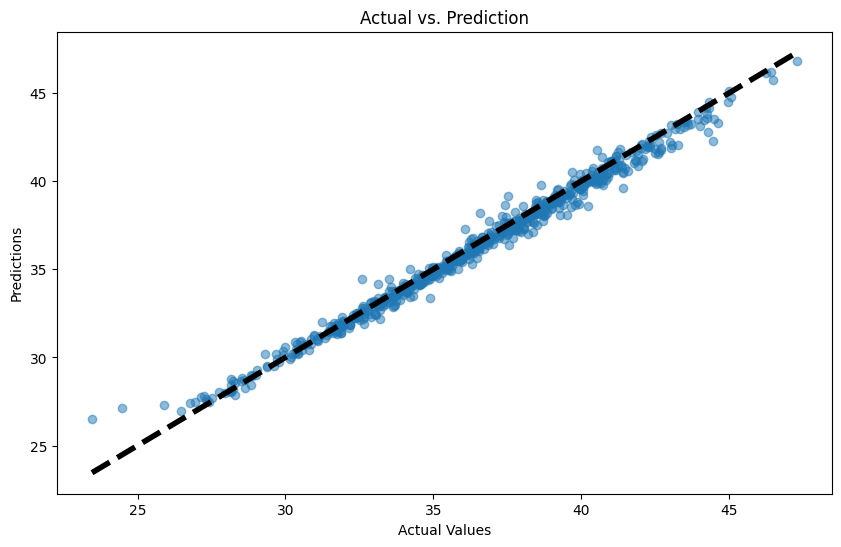

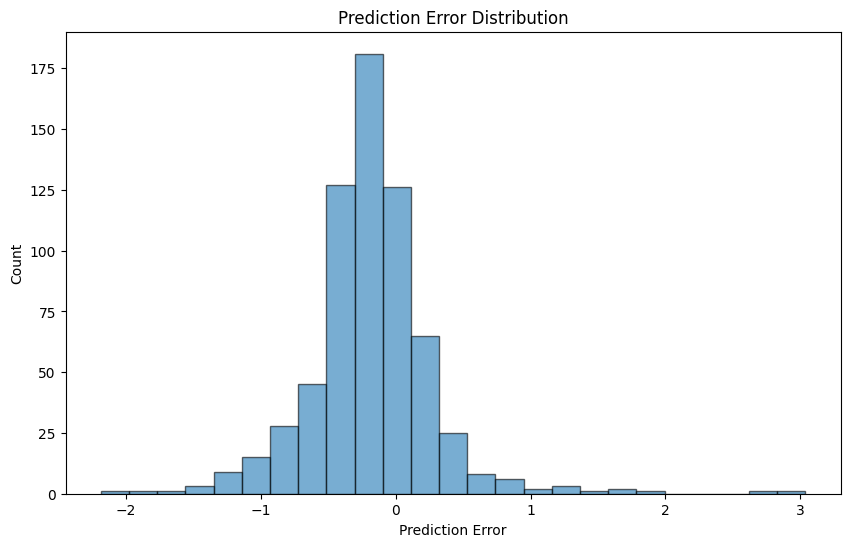

In [31]:
model_Performance(train_dataloader,model_performance[0][0])

[0, 5]


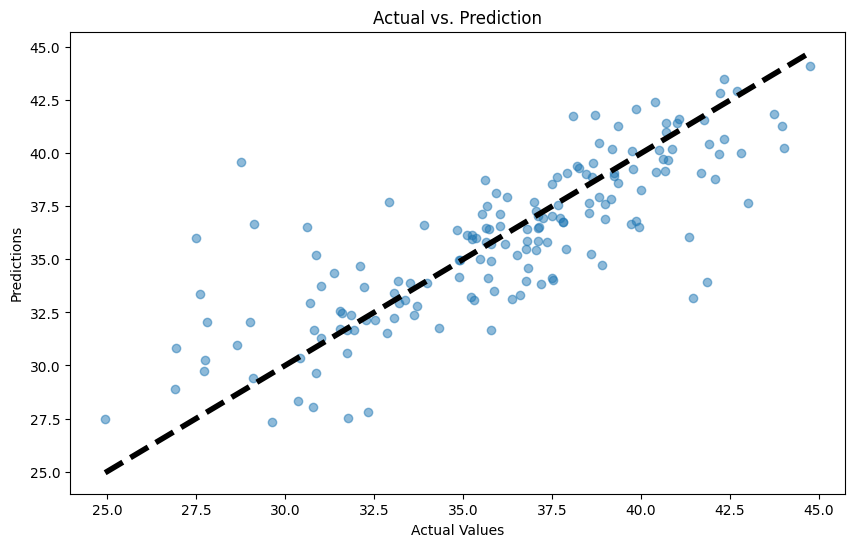

[2, 3]


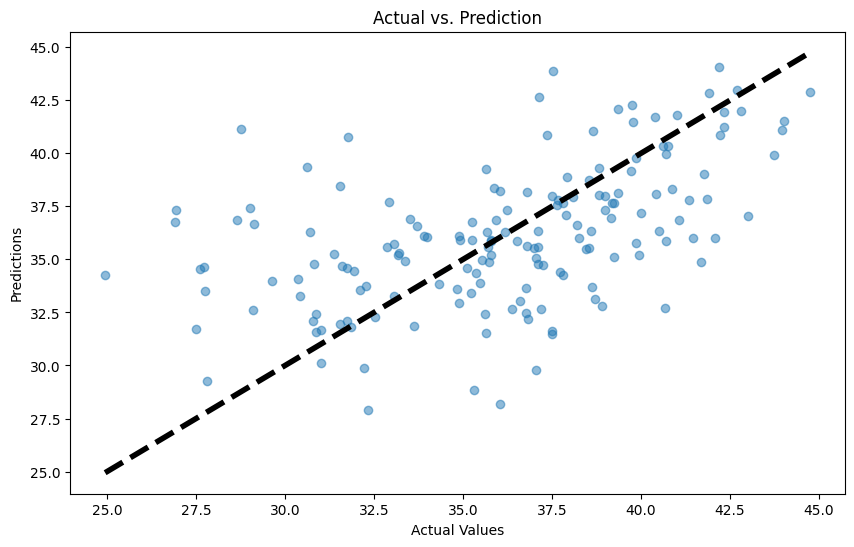

[0, 2, 3, 5]


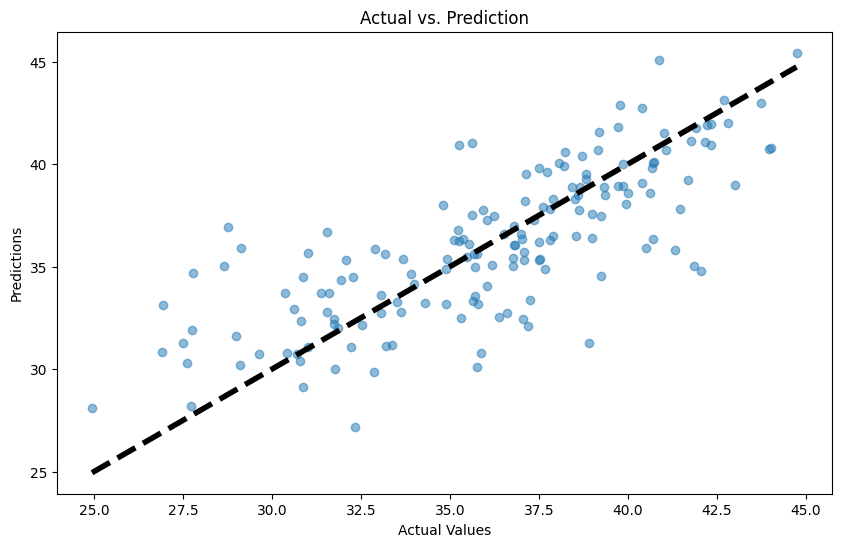

[0, 1, 4, 5]


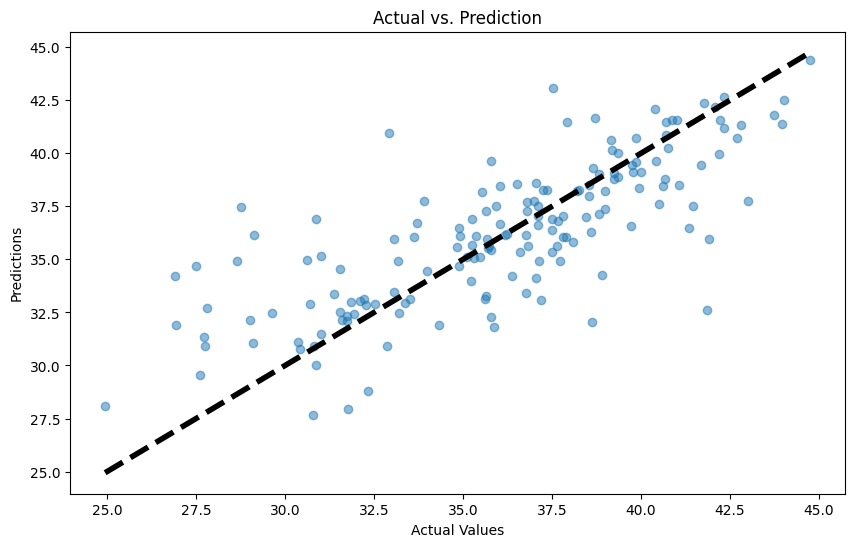

[0, 1, 2, 3, 4, 5]


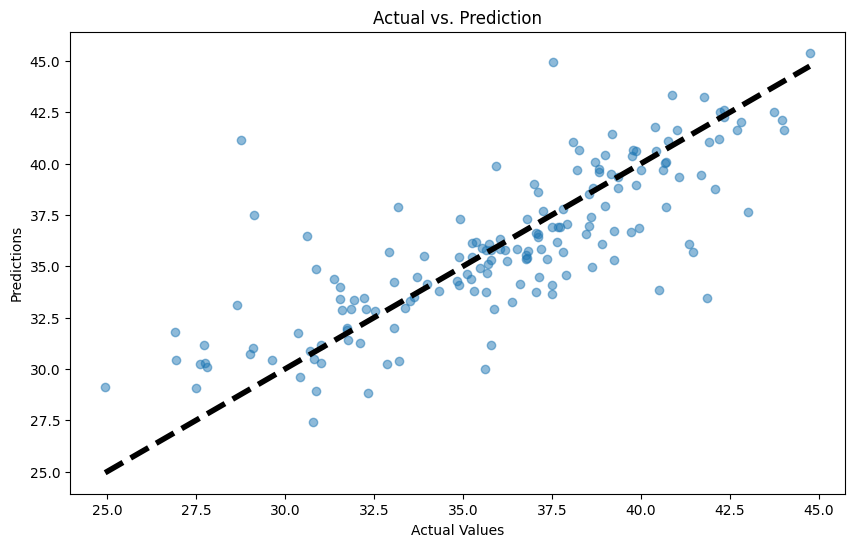

[6, 0, 1, 2, 3, 4, 5, 9]


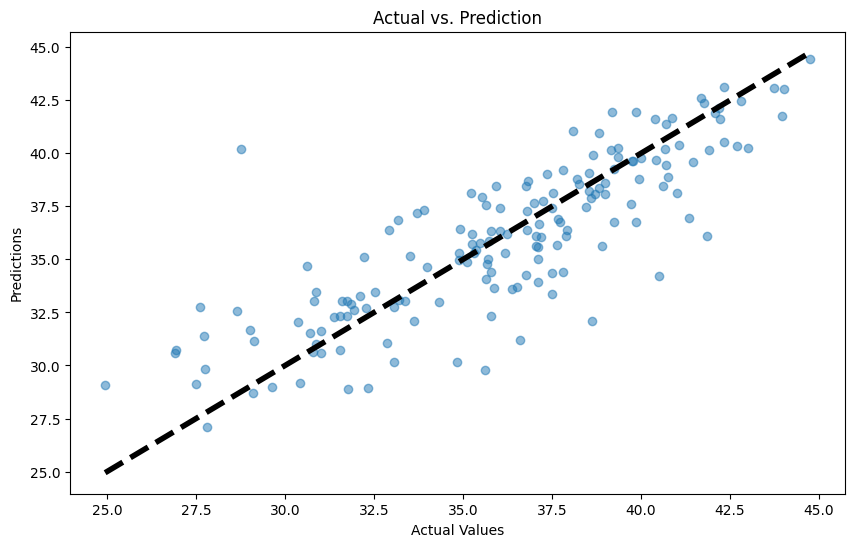

[0, 1, 2, 7, 8, 3, 4, 5]


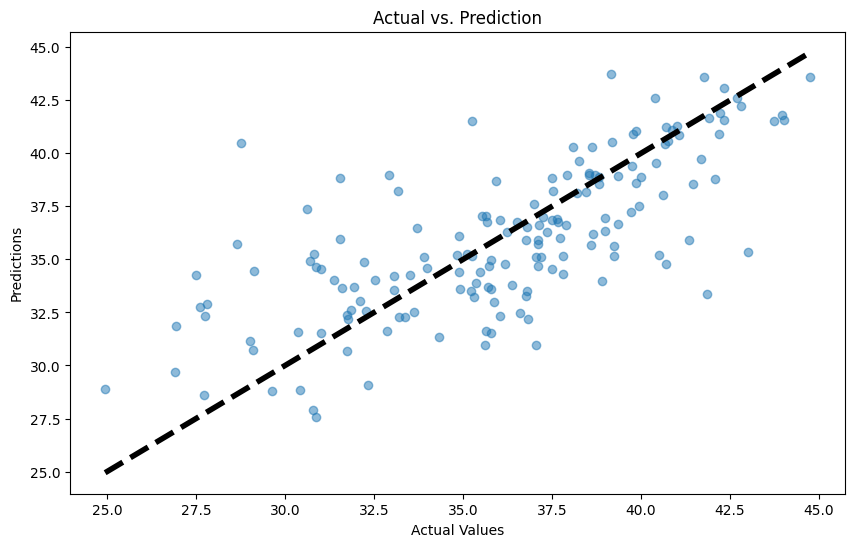

[6, 0, 1, 2, 7, 8, 3, 4, 5, 9]


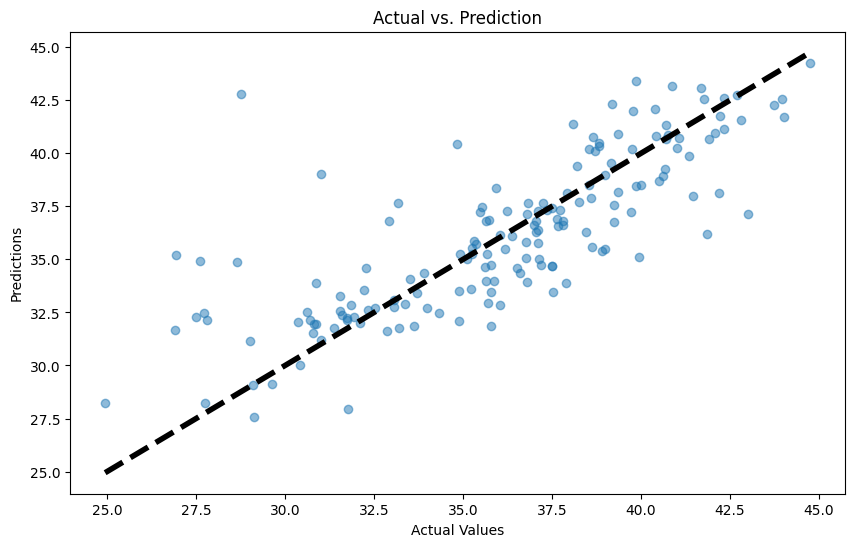

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


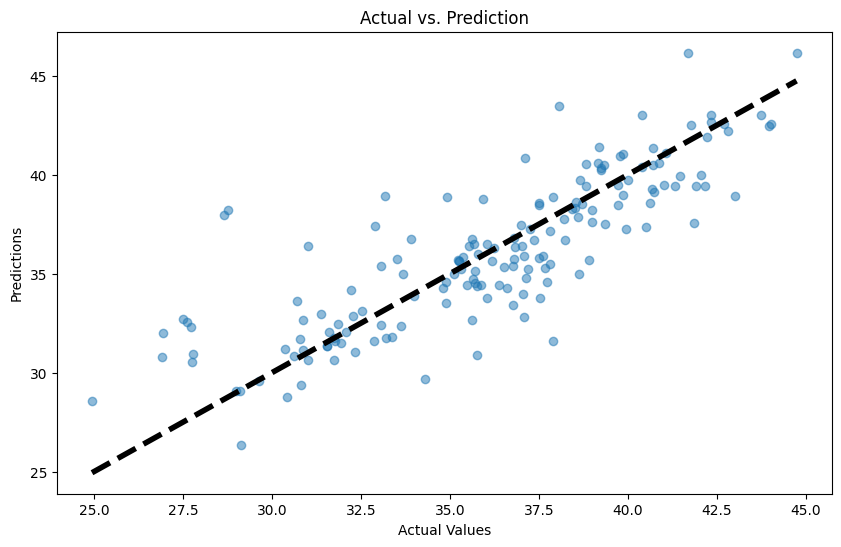

[5, 3, 2, 1, 0, 4]


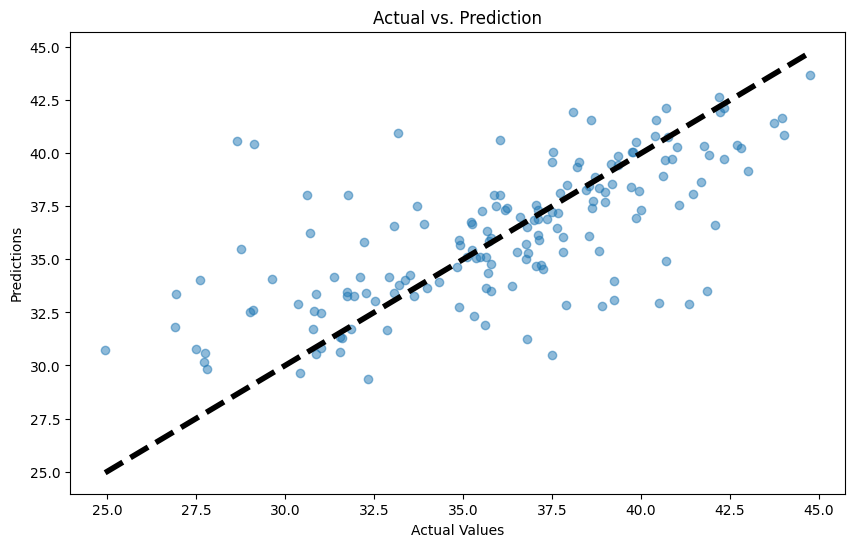

[5, 2, 2, 1, 3, 4]


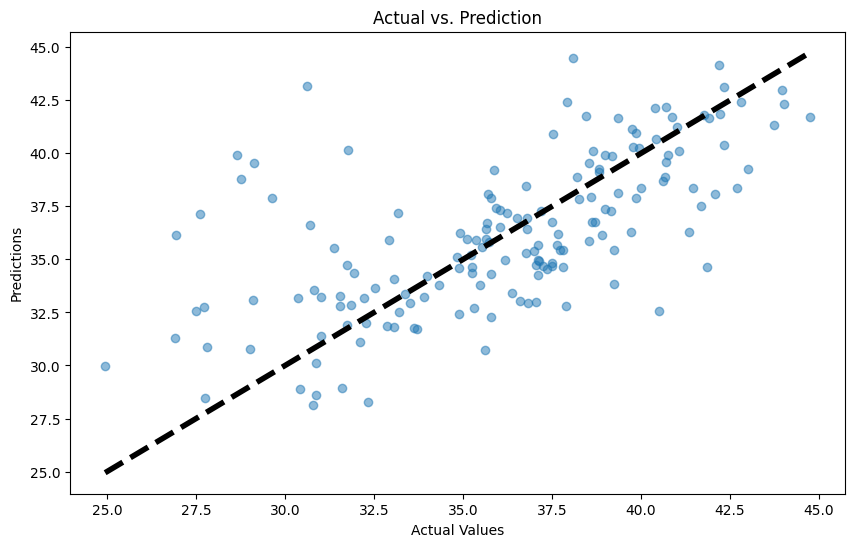

[0, 1, 2]


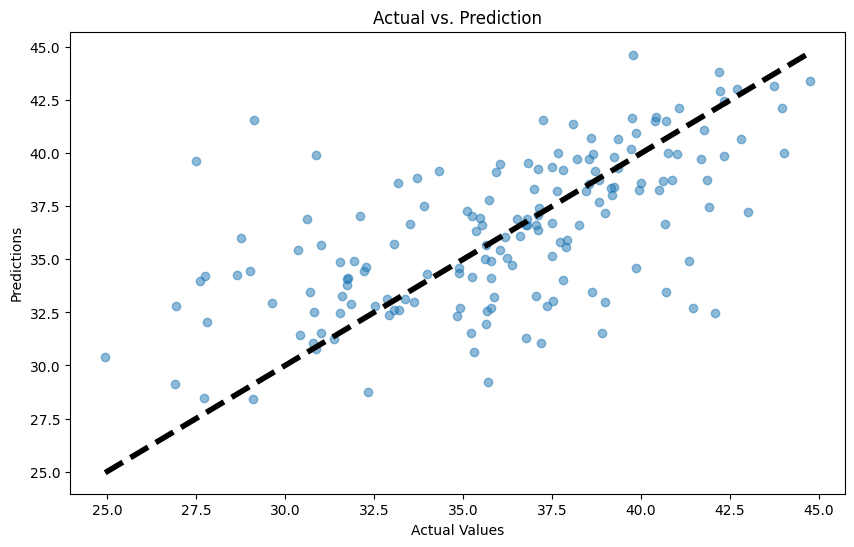

[5, 4, 3]


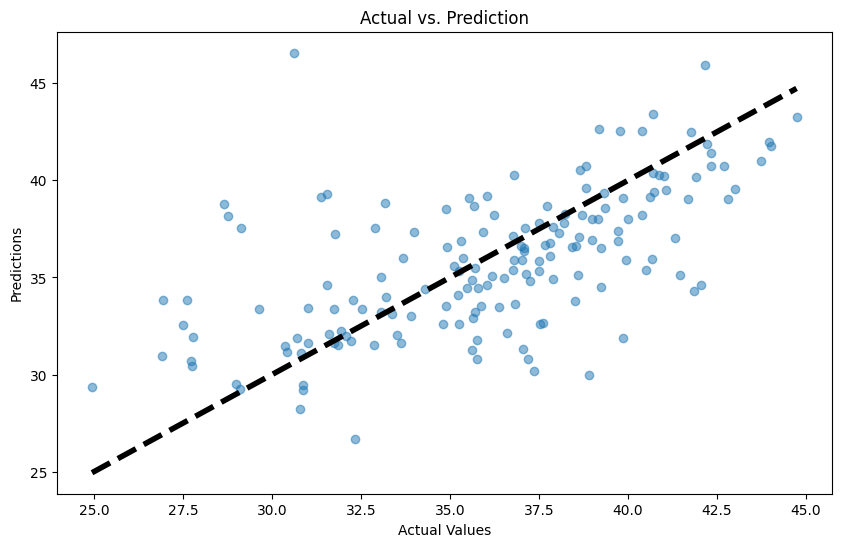

In [37]:
for i in range(len(model_performance)):
    atom_num = len(atom_list[i])
    dataset = get_datalist(data_list,atom_list[i])
    
    train_size = int(0.80 * len(dataset))
    test_size = len(dataset) - train_size
    
    torch.manual_seed(2025)
    # Randomly partition the data set
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
    
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    print(atom_list[i])
    model_Performance(test_dataloader,model_performance[i][0])

In [ ]:
model_performance=[]
for i in range(len(atom_list)):
    tmp = train_and_test(atom_list[i],data_list)
    print(atom_list[i],min(tmp[2]))
    model_performance.append(tmp)

In [49]:
for i in model_performance:
    print(i[1][-1],min(i[2]))

1.9890624444659164 5.683997815563565
2.141946042819721 12.927384421938942
2.0252130605825562 6.423762610980442
1.9611193635841695 6.171825618970962
2.006388535950242 5.850223694528852
1.9928933345690005 4.944186840738569
2.0140795882155254 7.3141859372456866
2.125855705360087 4.691398194858006
1.8022368786538518 4.957515313511803
1.9980265996078166 8.986219434511094
1.9839044264176997 8.831187997545515
1.810670943158429 10.365340431531271
2.207057625782199 10.420304003215971


In [45]:
atom_list

[[0, 5],
 [2, 3],
 [0, 2, 3, 5],
 [0, 1, 4, 5],
 [0, 1, 2, 3, 4, 5],
 [6, 0, 1, 2, 3, 4, 5, 9],
 [0, 1, 2, 7, 8, 3, 4, 5],
 [6, 0, 1, 2, 7, 8, 3, 4, 5, 9],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [5, 3, 2, 1, 0, 4],
 [5, 2, 2, 1, 3, 4],
 [0, 1, 2],
 [5, 4, 3]]

In [54]:
tmp = train_and_test(atom_list[0],data_list)

 72%|███████▏  | 715/1000 [19:33<07:47,  1.64s/it, Training=2.1, Validation=6.3]


KeyboardInterrupt: 

In [48]:
model_performance[0]=tmp

In [51]:
model_performance[0]

[60.953745190690206,
 37.307701895876626,
 39.76200878910902,
 36.92021687437848,
 27.71137917332533,
 28.389638993798233,
 31.87944269180298,
 27.02537220280345,
 27.99299400608714,
 23.800967379314145,
 25.98506138964397,
 27.484162127099385,
 25.736082792282104,
 30.33364144767203,
 27.468455343711668,
 21.002553904928813,
 22.169131244101177,
 23.77372966743097,
 20.548592253429135,
 23.100112228858762,
 20.58784145262183,
 18.82772286926828,
 21.953767567146116,
 19.701242981887447,
 18.721079791464458,
 16.29442048945078,
 18.308145139275528,
 16.899483157367243,
 18.502791486135344,
 16.398659403731184,
 16.419031143188477,
 14.76173215668376,
 15.08234065044217,
 16.295792870405243,
 13.616856197031533,
 12.742822164442481,
 12.674774069611619,
 12.672715469104487,
 14.440993274130472,
 12.528101700108225,
 12.615685695555152,
 10.90903106549891,
 11.31786818475258,
 12.052385612231928,
 10.725703931436307,
 10.49326621323097,
 10.872718675834376,
 10.546234011650085,
 11.26327

In [52]:
for i, result in enumerate(model_performance):
    model = result[0]  # 取出模型
    torch.save(model.state_dict(), f'model_{i}_weights.pth')
    print(f"Model {i} 已保存为 model_{i}_weights.pth")


Model 0 已保存为 model_0_weights.pth
Model 1 已保存为 model_1_weights.pth
Model 2 已保存为 model_2_weights.pth
Model 3 已保存为 model_3_weights.pth
Model 4 已保存为 model_4_weights.pth
Model 5 已保存为 model_5_weights.pth
Model 6 已保存为 model_6_weights.pth
Model 7 已保存为 model_7_weights.pth
Model 8 已保存为 model_8_weights.pth
Model 9 已保存为 model_9_weights.pth
Model 10 已保存为 model_10_weights.pth
Model 11 已保存为 model_11_weights.pth
Model 12 已保存为 model_12_weights.pth


In [53]:
import pickle

# 保存整个model_performance列表到文件
with open('model_performance.pkl', 'wb') as f:
    pickle.dump(model_performance, f)

print("model_performance 列表已经保存到 model_performance.pkl")


model_performance 列表已经保存到 model_performance.pkl


In [ ]:
model.eval()
total_val_loss = 0.0
with torch.no_grad():
    for x3d, x2d, x1d, x0d, targets  in test_dataloader:
        x3d, x2d, x1d, targets = x3d.to(device), x2d.to(device), x1d.to(device), targets.to(device)
        outputs = model(x3d,x2d,x1d)
        loss = criterion(outputs, targets)
        total_val_loss += loss.item()

avg_val_loss = total_val_loss / len(test_dataloader)

In [59]:
for i, result in enumerate(model_performance):
    atom_num = len(atom_list[i])
    dataset = get_datalist(data_list,atom_list[i])
    
    train_size = int(0.80 * len(dataset))
    test_size = len(dataset) - train_size
    
    torch.manual_seed(2025)
    # Randomly partition the data set
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
    
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)
    model = result[0]  # 取出模型
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for x3d, x2d, x1d, x0d, targets  in test_dataloader:
            x3d, x2d, x1d, targets = x3d.to(device), x2d.to(device), x1d.to(device), targets.to(device)
            outputs = model(x3d,x2d,x1d)
            loss = criterion(outputs, targets)
            total_val_loss += loss.item()
    
    avg_val_loss = total_val_loss / len(test_dataloader)
    print(avg_val_loss)

6.419627904891968
14.140694027855282
7.355205899193173
7.175068350065322
6.624742581730797
5.333665819395156
8.853744075411843
5.100932461874826
5.575939467975071
9.54849150067284
10.80225287732624
11.721324841181437
12.189002465634118


In [56]:
    criterion = nn.MSELoss()
